# **MFDCA Challenge**


---


Your task will be to distinguish masqueraders from benign users, from the history of bash commands using data mining methods

# Prepare
---
Imports, Constants and Downloads


## Download Data

In [24]:
!gdown --id 13dmRLgev8NwRpDIiIddjUu80ts4pUTgC
!unzip FraudedRawData.zip

Downloading...
From: https://drive.google.com/uc?id=13dmRLgev8NwRpDIiIddjUu80ts4pUTgC
To: /content/FraudedRawData.zip
100% 218k/218k [00:00<00:00, 66.0MB/s]


## Imports

In [25]:
import os,torch,time
import numpy as np
import csv, collections

from IPython.display import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import metrics
from keras.metrics import AUC

## Constants

In [26]:
data_path = "FraudedRawData"              # Users Data Folder
csv_label_path = "challengeToFill.csv"    # Label Data File

tokens_in_segment = 100                   # number of commands in a segment
n_users_train = 10                        # number of users with labeled segments (train users)
n_users_test = 30                         # number of users to predict on (test users)

train_segment_size = 50                   # number of first segements that are known that the owner owns them  (train set)
test_segment_size = 100                   # number of segments (after the train) that thier owner is not known (test set)
all_segment_size = train_segment_size + test_segment_size

tokens_in_train = tokens_in_segment * train_segment_size

stride = 1                                # stride (of segment window) for segment parser

embed_dim = 32                            # Embedding size for each token
num_heads = 5                             # Number of attention heads
ff_dim = 64                               # Hidden layer size in feed forward network inside transformer

n_users_fake_masqueraders = 10            # how many users to sample to be a fake masqueraders
n_seq_per_fake_masquerader = 0.1          # at range [0,1]. how much sequences to sample from each user (fake masquerader)

max_score_per_user = 90 * 1 + 10 * 9            # 90 benign segments (1 point) and 10 masqueraders segments (9 points) per user
max_score = max_score_per_user * n_users_train
score_normalizer = (4575 / 5400) * max_score    # legal premited error margin (~0.18%) for score smoothing

SEED= 42
np.random.seed(SEED)

# Model
---
We will train a Transformer NN Model for **each** of the users.
the objective of the model is to be able to seperate the user segments from other users segments


In [27]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [28]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [29]:
def get_model(vocab_size):
  """
  Creates A Transformer Model
  
  :return: 
    model, keras model
  """

  # model = keras.Sequential()
  # model.add(TokenAndPositionEmbedding(tokens_in_segment, vocab_size, embed_dim))
  # model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
  # model.add(layers.GlobalAveragePooling1D())
  # model.add(layers.Dense(2, activation="softmax"))
  
  input = keras.Input(shape=(tokens_in_segment,))
  emb = TokenAndPositionEmbedding(tokens_in_segment, vocab_size, embed_dim)(input)
  transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(emb)
  avg = layers.GlobalAveragePooling1D()(transformer)
  out = layers.Dense(2, activation="softmax")(avg)
  model = keras.Model(inputs=input, outputs=out)

  return model

In [30]:
def plot_model(vocab_size=751):
  """
  Plots the Transformer model
  """
  model = get_model(vocab_size)
  imageName = "model.png"
  tf.keras.utils.plot_model(model,show_shapes=True)
  display(Image(filename=imageName))

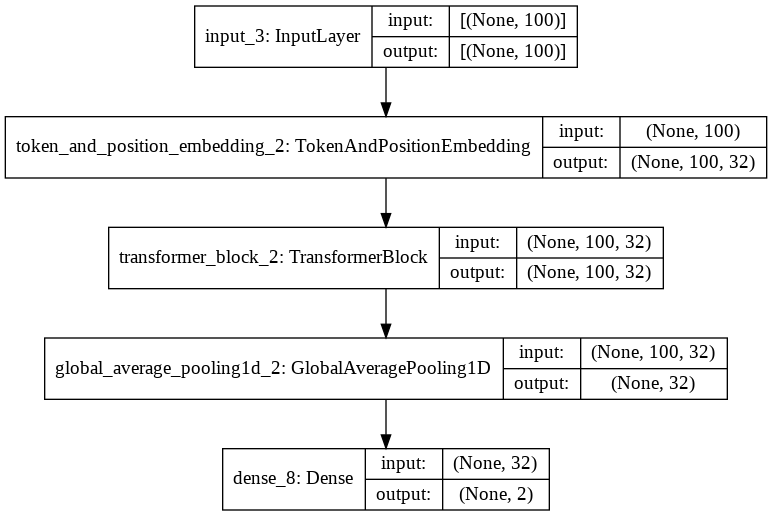

In [31]:
plot_model()

# Load and Pre-Process
---
Load all the data from disk for processing and prepare for training and testing

---
We are using transformer so we need samples to be sequences of commands. (so the transformer can learn the user history segments againts others history)
* segment is 100 commands so our sampling window will be 100 commands
* stride for the window = 1 (moving the window 1 command for each sample)

Samples and Labels:
* benign segments - the user's training segments (first 50). Label = [1,0]
* masquerader segments - creating 'fake masquerader' segments by sampling from a different user's (total of 10 for each user) sequences (first 10% of the fake sequences). Label = [0,1]

Test Samples:
the last 100 segments of each user (when stride = 100)


In [32]:
def load(commands_path):
  """
  Load users commands from disk, prepare segments 
  
  :param commands_path: users segments folder
  :return: 
    users: dict of format {user_id:(train_segments,test_segments)}
    sequences: array of sequences (created by a moving segment window) in all the training + test sets
    vocab: Counter, Count for all the commands in the dataset
  """
  users = {}
  sequences = []
  vocab = collections.Counter()

  for i, person_file in enumerate(os.listdir(commands_path)):
    if person_file.startswith("User"):
      user_file_path = os.path.join(commands_path, person_file)
      tokens = open(user_file_path).read().split()

      user_vocabulary = collections.Counter(tokens)
      vocab += user_vocabulary

      train_tokens = tokens[:tokens_in_train]
      train_segments = []
      
      test_tokens = tokens[tokens_in_train:]
      test_segments = []
      for j in range(0,len(train_tokens) - tokens_in_segment + 1,stride):
        segment = [token for token in train_tokens[j:j+tokens_in_segment]]
        train_segments.append(segment)
        sequences.append(segment)

      for j in range(0,len(test_tokens),tokens_in_segment):
        segment = [token for token in test_tokens[j:j+tokens_in_segment]]
        test_segments.append(segment)
        sequences.append(segment)

      users[int(person_file[len("User"):])] = (train_segments,test_segments)

  return users, sequences, vocab

In [33]:
users, sequences, vocab = load(data_path)

In [34]:
len(sequences) # number of sequences (created by a moving segment window) in all the training + test sets

200040

In [35]:
len(users[0][0]) # number of training sequences for each user

4901

In [36]:
# create a dict to translate: command -> index_command
word_index = {word:idx for idx,word in enumerate(vocab)}

In [37]:
vocab_size = len(word_index)

In [38]:
def load_labels(data, path):
    """
    Load the label data from a given the given file path
    
    :param data: users data (to get #users in the data set)
    :param path: path to the label csv file
    :return: 
      labels, ndarray of shape (#users, #test_segments) contains the labels for the segments (stride = 100)
    """
    labels = np.zeros((len(data), all_segment_size))

    user_id = 0
    header = True

    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            if header:
                header = False
                continue
            row = [token for token in row if token != '']
            if user_id < n_users_train:
                labels[user_id,] = np.asarray(row[1:])

            user_id += 1

    return labels

In [39]:
labels = load_labels(users, csv_label_path)

In [40]:
def extract_features(segment):
  """
  Extract features from a given segment
  convert the sequence of commands to a sequence of thier indexes

  :param segment: a given segment to process
  :return:
    processed, a segment (sequence) of commands indexes (int)
  """
  return [word_index[command] for command in segment]

def get_fake_samples(users_data, current_uid, label_one_ratio=n_seq_per_fake_masquerader, label_one_users=n_users_fake_masqueraders):
  """
  Creates Fake Masqueraders segments by sampling from a different user

  :param users_data: dict, users segments data
  :param current_uid: int, the id of the current user (so we can exclude him from the sampling users)
  :param label_one_ratio: float, at range [0,1]. how much sequences to sample from each user (fake masquerader)
  :param label_one_users: int, how many users to sample to be a fake masqueraders
  :return: 
    X_fake, fake segments sample array
    y_fake, fake segments label array
  """
  X_fake = []
  y_fake = []

  n_fake_samples = round(len(users_data[current_uid]["X"]) * label_one_ratio)

  labeld_one_idx = np.hstack([np.arange(current_uid),np.arange(current_uid+1,len(users_data))])

  uid_samples = np.random.choice(labeld_one_idx,label_one_users,replace=False)

  for i, uid in enumerate(uid_samples):
    for sid in range(n_fake_samples):
      X_fake.append(users_data[uid]["X"][sid])
      y_fake.append([0,1])

  return X_fake, y_fake

def create_train_test_set(users, labels, label_one_ratio=n_seq_per_fake_masquerader, label_one_users=n_users_fake_masqueraders):
  """
  Combines the informations and Creates all the needed data for training and testing

  :param users: dict, users training sequences and test segments
  :param labels: ndarray of shape (#users, #test_segments) contains the labels for the segments (stride = 100)
  :param label_one_ratio: float, at range [0,1]. how much sequences to sample from each user (fake masquerader)
  :param label_one_users: int, how many users to sample to be a fake masqueraders
  :return: 
    users_data: dict, training and testing samples and labels for each user (key = user id)
  """
  users_data = {}

  for user_id in range(len(users)):
    users_data[user_id] = {"X":[],"y":[],"X_test":[],"y_test":[]}
    train_segments,test_segments = users[user_id]
    # create training samples
    for seg_id in range(len(train_segments)):
      segment = train_segments[seg_id]

      sample = extract_features(segment)
      users_data[user_id]["X"].append(sample)
      users_data[user_id]["y"].append([1,0])
      
    # create test samples
    for seg_id in range(len(test_segments)):
      segment = test_segments[seg_id]

      sample = extract_features(segment)
      label = labels[user_id][train_segment_size + seg_id]

      users_data[user_id]["X_test"].append(sample)
      users_data[user_id]["y_test"].append(label)

  # create fake masqueraders samples
  for user_id in range(len(users_data)):
    X_fake, y_fake = get_fake_samples(users_data, user_id, label_one_ratio, label_one_users)
    users_data[user_id]["X"] += X_fake
    users_data[user_id]["y"] += y_fake

    users_data[user_id]["X"] = np.asarray(users_data[user_id]["X"])
    users_data[user_id]["y"] = np.asarray(users_data[user_id]["y"])
    users_data[user_id]["X_test"] = np.asarray(users_data[user_id]["X_test"])
    users_data[user_id]["y_test"] = np.asarray(users_data[user_id]["y_test"])

  return users_data

In [41]:
users_data = create_train_test_set(users, labels)

In [42]:
users_data[10]["X"].shape # how many training samples for each user

(9801, 100)

In [43]:
users_data[10]["y"].shape # how many training labels for each user

(9801, 2)

In [44]:
users_data[10]["X_test"].shape # how many test samples for each user

(100, 100)

In [45]:
users_data[10]["y_test"].shape # how many test labels for each user

(100,)

# Train
---
We will create a model for each user, train and predict the test samples


In [46]:
start_t = time.time()

# Training the Users Models
for user_id in range(len(users_data)):
    start_t_user = time.time()
    # create model
    model = get_model(vocab_size)
    model.compile("adam", "CategoricalCrossentropy", metrics=["accuracy",AUC(name="auc")])
    users_data[user_id]["Model"] = model

    print("-- Train Model, User {0:2} -----------------------------------------------------------------------------------".format(user_id))
    # fit
    users_data[user_id]["Model"].fit(users_data[user_id]["X"],users_data[user_id]["y"],batch_size=128, epochs=1)
    # predict probs
    users_data[user_id]["pred_test_prob"] = users_data[user_id]["Model"].predict(users_data[user_id]["X_test"])
    users_data[user_id]["pred_train_prob"] = users_data[user_id]["Model"].predict(users_data[user_id]["X"])
    # convert to classes
    users_data[user_id]["pred_test"] = np.argmax(users_data[user_id]["pred_test_prob"], axis=-1)
    users_data[user_id]["pred_train"] = np.argmax(users_data[user_id]["pred_train_prob"], axis=-1)
    # eval on all training samples for final metrics score
    acc = metrics.accuracy_score(users_data[user_id]["y"][:,1],users_data[user_id]["pred_train"])
    fpr, tpr, threshold = metrics.roc_curve(users_data[user_id]["y"][:,1], users_data[user_id]["pred_train"])
    roc_auc = metrics.auc(fpr, tpr)
    print("Done, elapsed[{} sec] metrics[Accuracy={}, AUC={}]".format(round(time.time() - start_t_user,3),round(acc,3),round(roc_auc,3)))
    print("-----------------------------------------------------------------------------------------------------------")
print("Done Training. elapsed {} sec".format(round(time.time() - start_t,3)))

-- Train Model, User  0 -----------------------------------------------------------------------------------
77/77 [==============================] - 2s 14ms/step - loss: 0.0941 - accuracy: 0.9694 - auc: 0.9610
Done, elapsed[3.658 sec] metrics[Accuracy=1.0, AUC=1.0]
-----------------------------------------------------------------------------------------------------------
-- Train Model, User  1 -----------------------------------------------------------------------------------
77/77 [==============================] - 2s 14ms/step - loss: 0.1860 - accuracy: 0.9162 - auc: 0.8906
Done, elapsed[3.601 sec] metrics[Accuracy=0.958, AUC=0.958]
-----------------------------------------------------------------------------------------------------------
-- Train Model, User  2 -----------------------------------------------------------------------------------
77/77 [==============================] - 2s 13ms/step - loss: 0.0870 - accuracy: 0.9615 - auc: 0.9372
Done, elapsed[3.527 sec] metrics[Accur

# Evaluate
---
We created a balanced training set:
10 (users) * 0.1 (user sequences) = 1 user sequences

for each of the 'Training Users' (first 10) We will evaluate:
* Accuaracy
* AUC
* Confusion Matrix
* Classification Report
* Assigment Score
* Assigment Score (smoothed)

Assigment Score:
* 1 point for predicing correct a benign user (label=0)
* 9 points for predicing correct a masquerader user (label=1)

** Assigment Score - normalized (allows up to 0.18% errors) will be calculated as well

For Test Users (last 30) we will count how many masquerader segments they predicted and compare to the training



In [47]:
def smooth(arr,n=10):
  """
  Smooth a given user segments prediction so that only the n'th highest probs will be
  consider as masqueraders (only n labels will be equal to 1 the others to 0)
  :param arr: array of floats (range [0,1]) a given array to smooth
  :param n: number of masqueraders segments to create from the probs
  :return: 
    smooth: smoothed arr with prediction classes
  """
  sorted_index_array = np.argsort(arr)
  sorted_array = arr[sorted_index_array]

  curr_n = n
  try_left = 3
  res_arr = arr.copy()
  while curr_n > 1:
    n_max = sorted_array[-curr_n : -curr_n+1]

    res_arr[res_arr < n_max] = 0
    res_arr[res_arr >= n_max] = 1

    if res_arr.sum() > n:
      curr_n -= 1
      try_left -= 1
      res_arr = arr.copy()
    else:
      break
  return res_arr

In [48]:
def eval(users_data):
  """
  Evaluate the models results

  :param users_data: dict, (key = user id) a given users info (trained model and samples) to eval
  :return: 
    result: ndarray of shape (#test users, #test segments). test segments results with predictions
  """
  result = np.zeros((n_users_test,test_segment_size))
  test_score = 0
  test_score_smooth = 0

  res_test_set = np.zeros((n_users_train,test_segment_size))

  for user_id in range(len(users_data)):
    
    if user_id < n_users_train:
      
      user_score = 0
      user_score_smooth = 0
      n_pred_one_but_zero = 0
      n_pred_zero_but_one = 0

      smooth_pred = smooth(users_data[user_id]["pred_test_prob"][:,1])

      for i, pred in enumerate(users_data[user_id]["pred_test"]):
        if pred == users_data[user_id]["y_test"][i]:
          user_score += 9 if users_data[user_id]["y_test"][i] == 1 else 1
        elif users_data[user_id]["y_test"][i] == 1:
          n_pred_zero_but_one += 1
        else:
          n_pred_one_but_zero += 1
        
        if smooth_pred[i] == users_data[user_id]["y_test"][i]:
          user_score_smooth += 9 if users_data[user_id]["y_test"][i] == 1 else 1

      acc = metrics.accuracy_score(users_data[user_id]["y_test"],users_data[user_id]["pred_test"])
      fpr, tpr, threshold = metrics.roc_curve(users_data[user_id]["y_test"], users_data[user_id]["pred_test"])
      roc_auc = metrics.auc(fpr, tpr)
      cf_mat = metrics.confusion_matrix(users_data[user_id]["y_test"], users_data[user_id]["pred_test"])
      cf_rep = metrics.classification_report(users_data[user_id]["y_test"], users_data[user_id]["pred_test"])

      test_score += user_score
      test_score_smooth += user_score_smooth
      res_test_set[user_id,] = users_data[user_id]["pred_test"].reshape(-1)
      print("== User: {} ================================\n* Accuracy: {}, AUC: {}.\n* Score: {}/{} ({}%), Score-Smooth: {}/{} ({}%).\n* confusion_mat:\n  Predicted '1' but '0' = {} | Predicted '0' but '1' = {} | FakeCount[{}/{}].\n{}\n\n* classification_report:\n{}\n===========================================".format(user_id,acc,round(roc_auc,3),user_score,max_score_per_user,round(user_score/max_score_per_user,3),user_score_smooth,max_score_per_user,round(user_score_smooth/max_score_per_user,3),n_pred_one_but_zero,n_pred_zero_but_one,users_data[user_id]["pred_test"].reshape(-1).sum(),10,cf_mat,cf_rep))

    else:
      n_fakes = users_data[user_id]["pred_test"].sum()
      result[user_id - n_users_train,] = users_data[user_id]["pred_test"].reshape(-1)
      print("User: {} (TEST USER) Fakes Found: {}/{}".format(user_id,n_fakes,10))

  print()    
  print("Total Train Score: {}/{} ({}%) | Normalized = {}%".format(test_score,max_score,round(test_score/max_score,3),min(1,round(test_score/score_normalizer,3))))
  print("Total Train Score - Smooth: {}/{} ({}%) | Normalized = {}%".format(test_score_smooth,max_score,round(test_score_smooth/max_score,3),min(1,round(test_score/score_normalizer,3))))
  print("Fakes Found in Train: {}/{} ({}%)".format(res_test_set.sum(),100,round(res_test_set.sum()/100,3)))

  return np.asarray(result,dtype=int)


In [49]:
result = eval(users_data)

== User: 0 ================================
* Accuracy: 0.9, AUC: 0.944.
* Score: 170/180 (0.944%), Score-Smooth: 160/180 (0.889%).
* confusion_mat:
  Predicted '1' but '0' = 10 | Predicted '0' but '1' = 0 | FakeCount[20/10].
[[80 10]
 [ 0 10]]

* classification_report:
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        90
         1.0       0.50      1.00      0.67        10

    accuracy                           0.90       100
   macro avg       0.75      0.94      0.80       100
weighted avg       0.95      0.90      0.91       100

== User: 1 ================================
* Accuracy: 0.7, AUC: 0.744.
* Score: 134/180 (0.744%), Score-Smooth: 130/180 (0.722%).
* confusion_mat:
  Predicted '1' but '0' = 28 | Predicted '0' but '1' = 2 | FakeCount[36/10].
[[62 28]
 [ 2  8]]

* classification_report:
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81        90
         1.0       0.2

In [50]:
print("Fakes Found in Test: {}/{} ({}%)".format(result.sum(),300,round(result.sum()/300,3)))

Fakes Found in Test: 478/300 (1.593%)


# Save Results
---
save results to csv file in the needed format (row = user, col= test segments)


In [51]:
def write_results(results):
  """
  Write result as a csv format (row = user, col= test segments)

  :param results: test segments result to write
  """
  with open('resuls.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)

    for user_id in range(len(results)):
      row = results[user_id]
      spamwriter.writerow(row)

In [52]:
write_results(result)